# Climate Modelling: Final Project

Investigating precipitation under global warming scenarios.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
sns.set_theme()

## Shared Socioeconomic Pathways

The atmospheric co2 concentration can be derived from these projected socioeconomic pathways, I use the preprocessed data from [ourworldindata](https://ourworldindata.org/explorers/ipcc-scenarios?facet=none&Metric=Greenhouse+gas+concentrations&Sub-metric=Carbon+dioxide+%28CO%E2%82%82%29&Rate=Per+capita&Region=Global&country=SSP1+-+Baseline~SSP2+-+Baseline~SSP3+-+Baseline~SSP4+-+Baseline~SSP5+-+Baseline).

In [2]:
ssps = pd.read_csv("../data/ipcc-scenarios.csv", usecols=["Scenario", "Year", "CO2 concentration"])
ssps["Scenario"].unique()
ssps

,Scenario,Year,CO2 concentration
0,SSP1 - 1.9,2005,379.85000
1,SSP1 - 1.9,2010,390.50530
2,SSP1 - 1.9,2020,412.14202
3,SSP1 - 1.9,2030,424.68152
4,SSP1 - 1.9,2040,425.52721
...,...,...,...
281,SSP5 - Baseline,2060,635.79256
282,SSP5 - Baseline,2070,730.02550
283,SSP5 - Baseline,2080,841.52016
284,SSP5 - Baseline,2090,963.84157


Note: Scenarios with numbers represent projected socioeconomic pathways which lead to this value of radiative forcing.

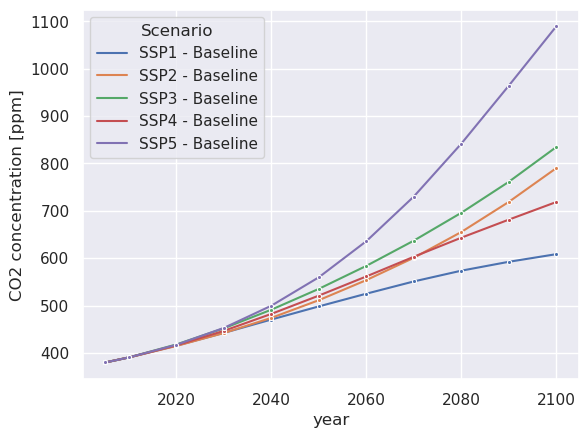

In [3]:
patternKeep = "Baseline"
filter = ssps["Scenario"].str.contains(patternKeep)
data = ssps[filter]

fig, ax = plt.subplots()
sns.lineplot(data=data, x="Year", y="CO2 concentration", hue="Scenario", marker=".", ax=ax)
ax.set_ylabel("CO2 concentration [ppm]")
ax.set_xlabel("year")
fig.savefig("../figs/ssps-pathways.png", dpi=300, bbox_inches="tight")

# TODO: add CO2 values for 2100

## Temperature

In [17]:
sims = ["SSP1", "SSP3", "SSP5", "plasim_ref_ln"]

t2m = {}
t2m_std = {}
time = {}

# get temperature values
for sce in sims:
    f = Dataset(f"../data/{sce}-tmp-clim.nc")
    time[sce] = f.variables["time"][:]
    # somehow, temperature is of shape (73, 1, 1)
    t2m[sce] = f.variables["t2m"][:].flatten()
    f.close()

# get standard devation
for sce in sims:
    f = Dataset(f"../data/{sce}-tmp-clim-std.nc")
    t2m_std[sce] = f.variables["t2m"][:].flatten()
    f.close()
    
# rename reference simulation
def change_key(d):
    d["reference"] = d["plasim_ref_ln"]
    del d["plasim_ref_ln"]
    
change_key(t2m)
change_key(t2m_std)
change_key(time)

# TODO: change time unit to something more comprehensible

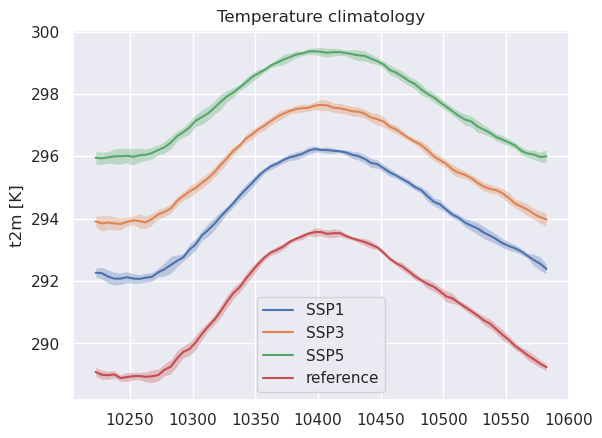

In [22]:
fig, ax = plt.subplots()
for sce in list(t2m.keys()):
    ax.plot(time[sce], t2m[sce], label=sce)
    ax.fill_between(time[sce], t2m[sce]-t2m_std[sce], t2m[sce]+t2m_std[sce], alpha=.3)
ax.legend()
ax.set_ylabel("t2m [K]")
ax.set_title("Temperature climatology");

## Precipitation

In [52]:
pr = {}

# get precipitation values
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-clim.nc")
    pr[sce] = f.variables["pr"][:].reshape(32, 64)

change_key(pr)
    
lon = f.variables["lon"][:]
lat = f.variables["lat"][:]

xlon, ylat = np.meshgrid(lon, lat)

# TODO: Change unit of precipitation

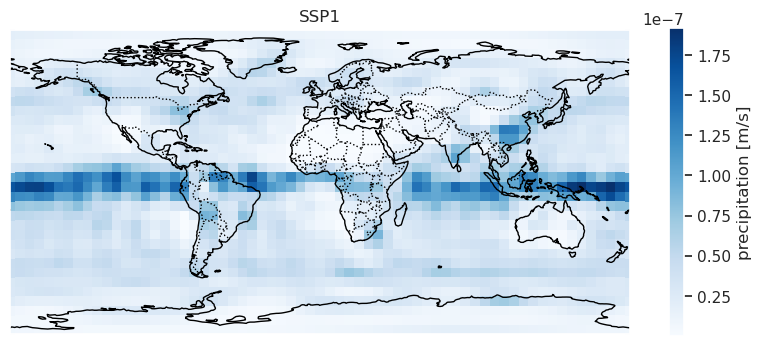

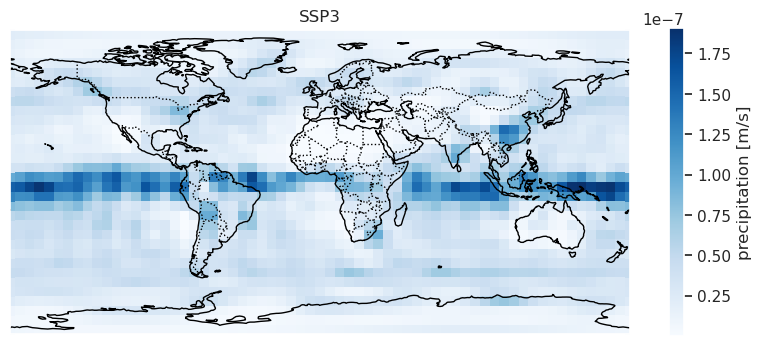

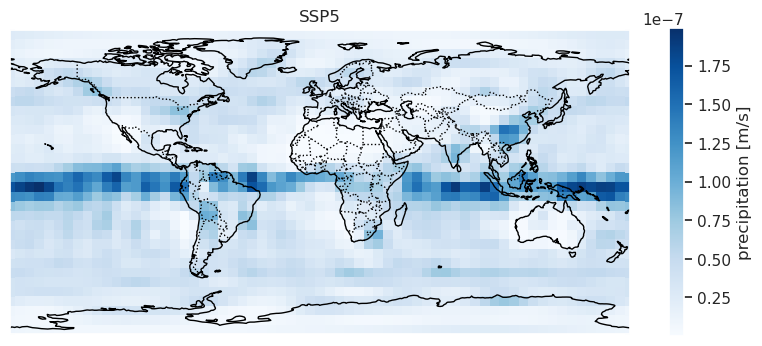

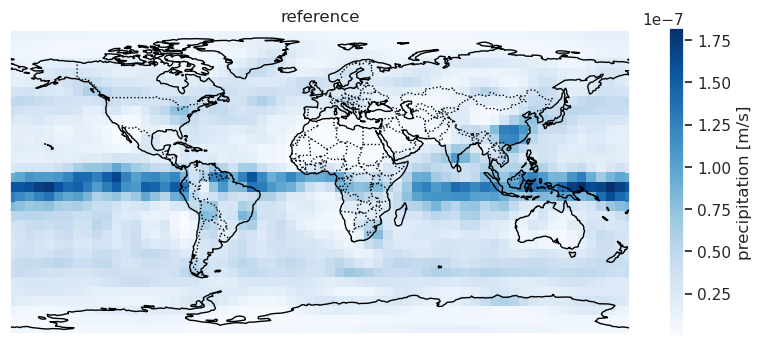

In [53]:
trans = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

for sce in list(pr.keys()):
    fig, ax = plt.subplots(figsize=(10,4), subplot_kw={"projection": proj})
    cm = ax.pcolormesh(xlon, ylat, pr[sce], transform=trans, cmap="Blues")
    cb = fig.colorbar(cm)
    cb.set_label("precipitation [m/s]")
    ax.set_title(sce)
    ax.add_feature(cfeature.BORDERS, ls=":")
    ax.add_feature(cfeature.COASTLINE)

## Anomalies?